# Práctica: detección de fraude mediante métodos de ensembles

ESTUDIANTES: 
- Renzo Carrasco Calle
- Anthony Guamán Mendoza

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/fraud.jpg" style="width:600px;">

En esta práctica vamos a utilizar todos los conocimientos adquiridos en los ejercicios anteriores, con el objetivo de construir un detector automático de fraude en pagos con tarjeta.

## Instrucciones

A lo largo del notebook encontrarás celdas que debes rellenar con tu propio código. Sigue las instrucciones del notebook y presta atención a los siguientes iconos:

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Deberás resolver el ejercicio escribiendo tu propio código o respuesta en la celda inmediatamente inferior.
    <b>La nota máxima que puede obtenerse con esta clase de ejercicios es de 7 sobre 10.</b>
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
Esto es una pista u observación de utilidad que puede ayudarte a resolver el ejercicio. Presta atención a estas pistas para comprender el ejercicio en mayor profundidad.
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/pro.png" height="80" width="80" style="float: right;"/>

***
<font color=#259b4c>
Este es un ejercicio avanzado que te puede ayudar a profundizar en el tema, y a conseguir una calificación más alta. <b>Resolviendo esta clase de ejercicios puedes llegar conseguir hasta 3 puntos sobre 10.</b> ¡Buena suerte!</font>

***

Para evitar problemas con imports o incompatibilidades se recomienda ejecutar este notebook en uno de los [entornos de Ensembles recomendados](https://github.com/albarji/teaching-environments-ensembles).

El siguiente código mostrará todas las gráficas en el propio notebook en lugar de generar una nueva ventana.

In [490]:
!pip install xgboost

In [491]:
!pip install catboost

   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   --- ------------------------------------ 9.2/101.7 MB 51.8 MB/s eta 0:00:02
   ------- -------------------------------- 19.9/101.7 MB 50.4 MB/s eta 0:00:02
   -------- ------------------------------- 22.5/101.7 MB 37.6 MB/s eta 0:00:03
   ------------- -------------------------- 33.3/101.7 MB 39.9 MB/s eta 0:00:02
   ---------------- ----------------------- 43.0/101.7 MB 41.4 MB/s eta 0:00:02
   -------------------- ------------------- 53.2/101.7 MB 42.4 MB/s eta 0:00:02
   ------------------------ --------------- 62.7/101.7 MB 42.9 MB/s eta 0:00:01
   -------------------------- ------------- 66.6/101.7 MB 39.3 MB/s eta 0:00:01
   ----------------------------- ---------- 75.0/101.7 MB 39.2 MB/s eta 0:00:01
   -------------------------------- ------- 83.6/101.7 MB 39.2 MB/s eta 0:00:01
   ----------------------------------- ---- 91.2/101.7 MB 38.6 MB/s eta 0:00:01
   ------------------------------------- -- 94.9/1

In [494]:
!pip install lightgbm

In [504]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, average_precision_score, PrecisionRecallDisplay
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

%matplotlib inline

## Carga y preparación de datos

Para este problema usaremos una versión reducida de los datos disponibles en la competición de Kaggle [IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection/data). Los datos a emplear están incluidos en la carpeta *data*, con ficheros separados para entrenamiento y test. Cada fichero incluye una gran cantidad de variables explicativas sobre la naturaleza de la operación con tarjeta realizada: puede encontrarse información sobre la naturaleza de estas variables en las [discusiones de la competición](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203). La variable objetivo es `isFraud`, la cual toma el valor 1 para operaciones fraudulentas.

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Carga los datos de entrenamiento y test en sendos Pandas DataFrames con nombres <b>train</b> y <b>test</b>, respectivamente.
</font>

***

In [317]:
# Leyendo datos
train = pd.read_csv('data/train.csv')

# Mostrando 5 valores al azar
train.sample(5)

,Unnamed: 0,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
7634,453086,3440086,0,11570172,49.00,W,7311,555.0,150.0,visa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16739,253070,3240070,0,6041577,117.00,W,7970,490.0,150.0,visa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58091,128397,3115397,0,2561822,107.95,W,7919,194.0,150.0,mastercard,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47954,183534,3170534,1,4059559,390.00,W,10960,567.0,150.0,mastercard,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36440,25534,3012534,0,663938,49.00,W,16437,514.0,150.0,mastercard,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [318]:
# Leyendo datos
test = pd.read_csv('data/test.csv')

# Mostrando 5 valores al azar
test.sample(5)

,Unnamed: 0,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
10126,397099,3384099,0,10004972,117.000,W,7508,321.0,150.0,visa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4605,20051,3007051,0,517822,100.000,R,15479,520.0,150.0,american express,...,0.0,0.0,50.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0
54178,95850,3082850,0,1966446,146.566,C,17782,408.0,185.0,visa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38746,582022,3569022,0,15542481,23.608,C,9633,130.0,185.0,visa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18881,39281,3026281,0,955634,335.000,W,15497,490.0,150.0,visa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Explorando valores de las variables
def print_column_unique_values(df, top_n=5):
    """
        Función que imprime los n valores más frecuentes en cada columna del DataFrame.
        
        Parámetros:
        
        df: El DataFrame de entrada.
        top_n (int): El número de valores más frecuentes a mostrar (5 por default).
    """
    # Iterar por cada feature del dataframe
    for column_name, column_data in df.items():
        # Value counts de cada feature
        value_counts = column_data.value_counts()
        
        # Imprimir conteo
        print(f"{column_name} tiene {len(value_counts)} valores únicos")
        
        # Lista con los top n valores con mayor frecuencia de conteo de cada feature
        value_count_list = [
            f"'{value}': {count}" for value, count in sorted(value_counts.items(), key=lambda item: item[1], reverse=True)
        ]
        
        # Imprimir el top n valores con su conteo
        top_values = ", ".join(value_count_list[:min(len(value_count_list), top_n)])
        print(top_values)
        print ('\n')


# Se analizan las columnas del dataframe con la anterior función
print_column_unique_values(train)

Unnamed: 0 tiene 60000 valores únicos
'229713': 1, '112778': 1, '392669': 1, '267926': 1, '238770': 1


TransactionID tiene 60000 valores únicos
'3216713': 1, '3099778': 1, '3379669': 1, '3254926': 1, '3225770': 1


isFraud tiene 2 valores únicos
'0': 50000, '1': 10000


TransactionDT tiene 59809 valores únicos
'7693358': 3, '5334992': 3, '2863295': 2, '345481': 2, '7223339': 2


TransactionAmt tiene 5792 valores únicos
'59.0': 2862, '117.0': 2857, '107.95': 2226, '100.0': 2063, '57.95': 2035


ProductCD tiene 5 valores únicos
'W': 42045, 'C': 9202, 'R': 3982, 'H': 3520, 'S': 1251


card1 tiene 6059 valores únicos
'9500': 1493, '7919': 1386, '15885': 1138, '17188': 1034, '15066': 826


card2 tiene 500 valores únicos
'321.0': 4894, '111.0': 4363, '555.0': 4132, '490.0': 3794, '583.0': 2215


card3 tiene 77 valores únicos
'150.0': 50785, '185.0': 7836, '106.0': 154, '144.0': 152, '119.0': 112


card4 tiene 4 valores únicos
'visa': 39024, 'mastercard': 19205, 'american express': 839, 'dis

Los datos a utilizar presentan algunas problemáticas que debes resolver antes de pasar a la construcción de modelos:
* Valores de variables expresados como strings. scikit-learn no acepta variables expresadas de esta forma.
* Valores faltantes en muchas variables. Aunque varios modelos de scikit-learn pueden trabajar con valores faltantes sin problemas, otros modelos fallarán al encontrarlos.

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Aplica las transformaciones que creas necesarias para tener los datos listos para el modelado. Ten en cuenta que cualquier proceso realizado debe aplicarse tanto a los datos de train como a los de test.
</font>

***

In [319]:
# ELiminado variables que no aportan información (columna Id duplicada)
train = train.drop(columns = ['Unnamed: 0'], axis = 1)
test = test.drop(columns = ['Unnamed: 0'], axis = 1)

In [321]:
# Identificando columnas con muchos valores nulos                 
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

In [322]:
# Identificando columnas con un valor dominante excesivo (más del 90% de las filas comparten el mismo valor)
big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

In [323]:
# Identificando columnas con un solo valor 
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

In [324]:
# Identificando número de columnas a eliminar
cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols+ one_value_cols_test))
print(f'Columnas a eliminar: {len(cols_to_drop)}')

Columnas a eliminar: 52


In [325]:
# Eliminando columnas en train y test
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [338]:
# Seleccionando columnas categóricas 
cat_cols = ['ProductCD',  
            'card1', 'card2', 'card3',  'card4', 'card5', 'card6', 
            'addr1', 'addr2',
            'P_emaildomain', 'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 
            'R_emaildomain', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3',
            'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

# Convirtiendo variables categóricas a 'one-hot'
for col in cat_cols:
    if col in train.columns:
        encoder = OneHotEncoder(sparse_output=False)
        # Asegurarse de que los datos tienen la forma correcta (n_filas, 1)
        values = list(train[col].astype(str).values) + list(test[col].astype(str).values)
        reshaped_values = np.array(values).reshape(-1, 1)  # Convertir a 2D
        encoder.fit(reshaped_values)

        # Aplicar transformación a train y test
        train[col] = encoder.transform(np.array(train[col].astype(str).values).reshape(-1, 1))
        test[col] = encoder.transform(np.array(test[col].astype(str).values).reshape(-1, 1))

In [340]:
# Ordenando por fecha de transanción y eliminando columna (ya que no es timestamp real)
train = train.sort_values('TransactionDT').drop(['TransactionDT'], axis=1)
test = test.sort_values('TransactionDT').drop(['TransactionDT'], axis=1)

In [ ]:
'''
# ELiminando columnas altamente correlacionadas
# Calcular matriz de correlación
correlation_matrix = train.corr()

# Umbral de correlación
threshold = 0.9

# Identificar grupos de columnas correlacionadas
groups = {}  # Diccionario para almacenar grupos
for col in correlation_matrix.columns:
    for group in groups.values():
        if any(abs(correlation_matrix[col][member]) > threshold for member in group):
            group.append(col)
            break
    else:
        groups[len(groups)] = [col]  # Crear un nuevo grupo si no encaja en ninguno

# Seleccionar una columna por grupo (criterio: columna con mayor varianza)
selected_columns = [train[group].var().idxmax() for group in groups.values()]

# Mostrando columnas a eliminar
print(f'Columnas a eliminar: {len(train.columns) - len(selected_columns)}')
'''

In [341]:
# Filtrar columnas de train y test
train = train[selected_columns]
test = test[selected_columns]

In [336]:
import gc
del train_chunk, test_chunk, train_imputed_chunk, test_imputed_chunk
gc.collect()

11805

In [342]:
# Dividir en bloques
chunk_size = 5000  # Número de filas por bloque
num_chunks =  max(1, train.shape[0] // chunk_size)  # Evita un 0 como resultado

train_imputed_chunks = []
test_imputed_chunks = []

# Utilizar KNNImputer con parámetros por defecto
imputer = KNNImputer()

for i in range(num_chunks):
    print(f"Imputando bloque {i+1}/{num_chunks}...")
    train_chunk = train.iloc[i * chunk_size:(i + 1) * chunk_size]
    test_chunk = test.iloc[i * chunk_size:(i + 1) * chunk_size]

    train_imputed_chunk = pd.DataFrame(imputer.fit_transform(train_chunk), columns=train_chunk.columns)
    test_imputed_chunk = pd.DataFrame(imputer.transform(test_chunk), columns=test_chunk.columns)

    train_imputed_chunks.append(train_imputed_chunk)
    test_imputed_chunks.append(test_imputed_chunk)

# Reconstruir el DataFrame completo
train_imputed = pd.concat(train_imputed_chunks, axis=0).reset_index(drop=True)
test_imputed = pd.concat(test_imputed_chunks, axis=0).reset_index(drop=True)

# Verificando imputación
print("\nImputación KNN completada para todos los datos. \n")
print("¿Hay valores faltantes en train?", any(train_imputed.isnull().sum()))
print("¿Hay valores faltantes en test?", any(test_imputed.isnull().sum()))

Imputando bloque 1/12...
Imputando bloque 2/12...
Imputando bloque 3/12...
Imputando bloque 4/12...
Imputando bloque 5/12...
Imputando bloque 6/12...
Imputando bloque 7/12...
Imputando bloque 8/12...
Imputando bloque 9/12...
Imputando bloque 10/12...
Imputando bloque 11/12...
Imputando bloque 12/12...
Imputación KNN completada para todos los datos.
Valores faltantes después de la imputación en train: False
Valores faltantes después de la imputación en test: False


## Midiendo el rendimiento de un detector de fraude

Las actividades fraudulentas son constantemente perseguidas, por lo que los defraudadores necesitan ser creativos e inventar nuevas formas de llevar a cabo sus fraudes. Además, afortunadamente, las operaciones fraudulentas son relativamente escasas, lo que nos lleva a contar con pocos casos positivos para entrenar el modelo. Dicho de otro modo, nos enfrentamos a un problema altamente desequilibrado, lo cual dificulta el entrenamiento del modelo, así como su evaluación.

Consideremos un modelo trivial que clasifica todos los casos como negativos (operaciones legítimas). Podemos simular las predicciones de este modelo creando un vector de predicciones de todo ceros:

In [144]:
dumbpreds = [0] * len(test)

Midamos el porcentaje de acierto de este modelo sobre el conjunto de test

In [146]:
from sklearn.metrics import accuracy_score

accuracy_score(test["isFraud"], dumbpreds)

0.8333333333333334

Deberías haber obtenido en torno a un 83% de acierto, ya que la gran mayoría de casos son negativos. A pesar de eso, ¡este modelo es totalmente inútil como detector de fraudes! Por tanto, necesitamos una métrica mejor.

Una métrica que funciona bien para problemas muy desbalanceados es el [área bajo la curva ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic), o AUC. En scikit-learn esta métrica está disponible, y podemos probarla para comprobar que el rendimiento de este modelo es realmente malo

In [148]:
from sklearn.metrics import roc_auc_score

roc_auc_score(test["isFraud"], dumbpreds)

0.5

Un AUC del 50% indica que el modelo no es mejor que lanzar predicciones aleatoriamente. Si evaluáramos un modelo en el que las predicciones de probabilidad de la clase fraude fueran algo más altas para los casos realmente fraudulentos que para los casos legítimos, veríamos cómo el AUC produce mayores valores. El caso óptimo para esta métrica es un modelo en el que todos los casos de fraude son predichos con una mayor probabilidad de fraude que todos los casos de operaciones legítimas.

## Detector de fraude no supervisado

Dado que apenas tenemos datos de fraude, puede tener sentido empezar construyendo un modelo no supervisado.


<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    Usando <b>solo los datos de train</b>, y sin emplear la variable <i>Class</i>, construye un modelo de tipo IsolationForest para detección de anomalías. Mide el rendimiento del modelo sobre el conjunto de test, usando la métrica AUC.
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
Ten en cuenta los siguientes puntos para construir un buen modelo:
    <ul>
        <li>Puedes estimar el parámetro <i>contamination</i> como la proporción de datos fraudulentos del conjunto de entrenamiento.</li>
        <li>Por defecto IsolationForest emplea pocos árboles. Asegúrate de probar con diferentes números de árboles.</li>
        <li>La métrica AUC necesita recibir las <b>probabilidades de clase fraude</b> para funcionar correctamente. No es posible obtener probabilidades de un IsolationForest, pero puedes hacer uso de su función <i>score_samples</i> para obtener scores (profundidades medias en el árbol), los cuales pueden ser negados para obtener valores que pueden interpretarse como probabilidades de clase fraude (no normalizadas).</li>
    </ul>
    Si has entrenado el modelo correctamente, deberías obtener en torno a un <b>94% de AUC</b>.
</font>

***

In [345]:
# Creando columnas X y Y
X_train = train_imputed.drop('isFraud', axis = 1)
y_train = train_imputed['isFraud']
X_test = test_imputed.drop('isFraud', axis = 1)
y_test = test_imputed['isFraud']

# Proporción de datos fraudulentos
rate_fraud = train_imputed['isFraud'].sum()/len(train_imputed['isFraud'])

# Creando modelo
isoforest = IsolationForest(n_estimators = 5000, contamination = rate_fraud, bootstrap = True, random_state=21, n_jobs = -1)

# Entrenando modelo
isoforest.fit(X_train)

# Calculando probabilidades de clase fraude
y_scores = - isoforest.score_samples(X_test)

# Calculando auc-score
auc_score_isoforest = roc_auc_score(y_test, y_scores)
print(f'Roc-auc score: {auc_score_isoforest}')

0.664500671


<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    Crea una visualización mostrando el rendimiento de este modelo sobre los datos de test.
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
Sugerencia: utiliza la <a href=https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html>visualización ROC que se presenta en la documentación de scikit-learn</a>.
</font>

***

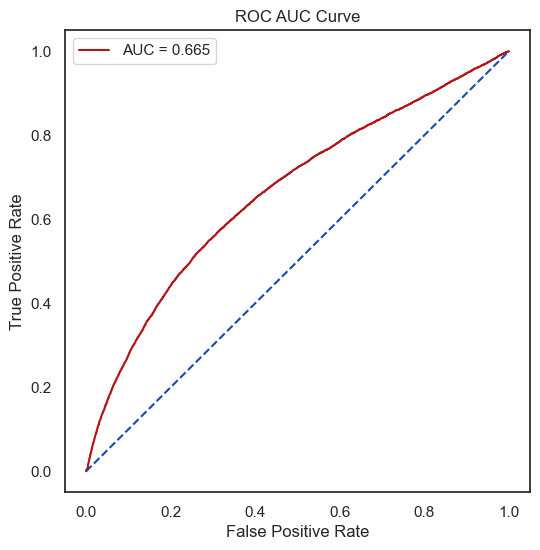

In [377]:
#  Curva ROC
# Calculando tasa de falsos positivos y AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(false_positive_rate, true_positive_rate)

# Construyendo gráfico
sns.set_theme(style = 'white')
plt.figure(figsize = (6, 6))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC AUC Curve')
plt.legend()

# Mostrando gráfico
plt.show()

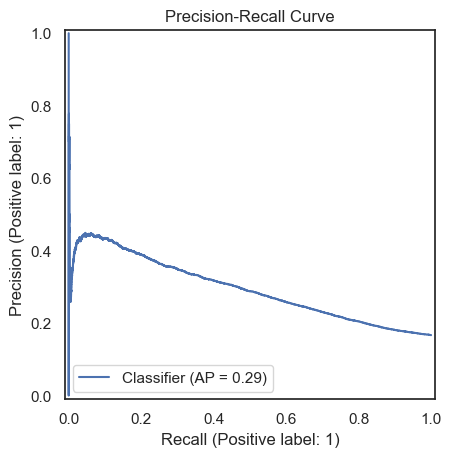

In [398]:
#Precision Recall Curve
PrecisionRecallDisplay.from_predictions(y_test, y_scores)
plt.title('Precision-Recall Curve')

# Mostrando el gráfico
plt.show()

## Árbol de detección de fraude

Ahora vamos a comprobar si un método supervisado sencillo e interpretable, como es un árbol de decisión, puede ayudarnos a resolver este problema.

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    Entrena un árbol de decisión sobre los datos de train, haciendo uso tanto de las variables explicativas como de la variable objetivo. Trata de que el árbol sea sencillo, de forma que puedas generar una visualización interpretable del mismo. Mide también los resultados del árbol en AUC sobre el conjunto de test. ¿Obtienes mejoras sobre el modelo no supervisado?
</font>

***

In [454]:
# Entrenando árbol de decisión
dtree = DecisionTreeClassifier(max_depth = 4, class_weight={0.0: 1, 1.0: 4}, random_state = 21) 
dtree.fit(X_train, y_train)

# Predicción de la clase positiva 
y_probs = dtree.predict_proba(X_test)[:, 1]

# Calculando auc-score
auc_score = roc_auc_score(y_test, y_probs)
print(f'Roc-auc score: {auc_score}')

Roc-auc score: 0.826431183


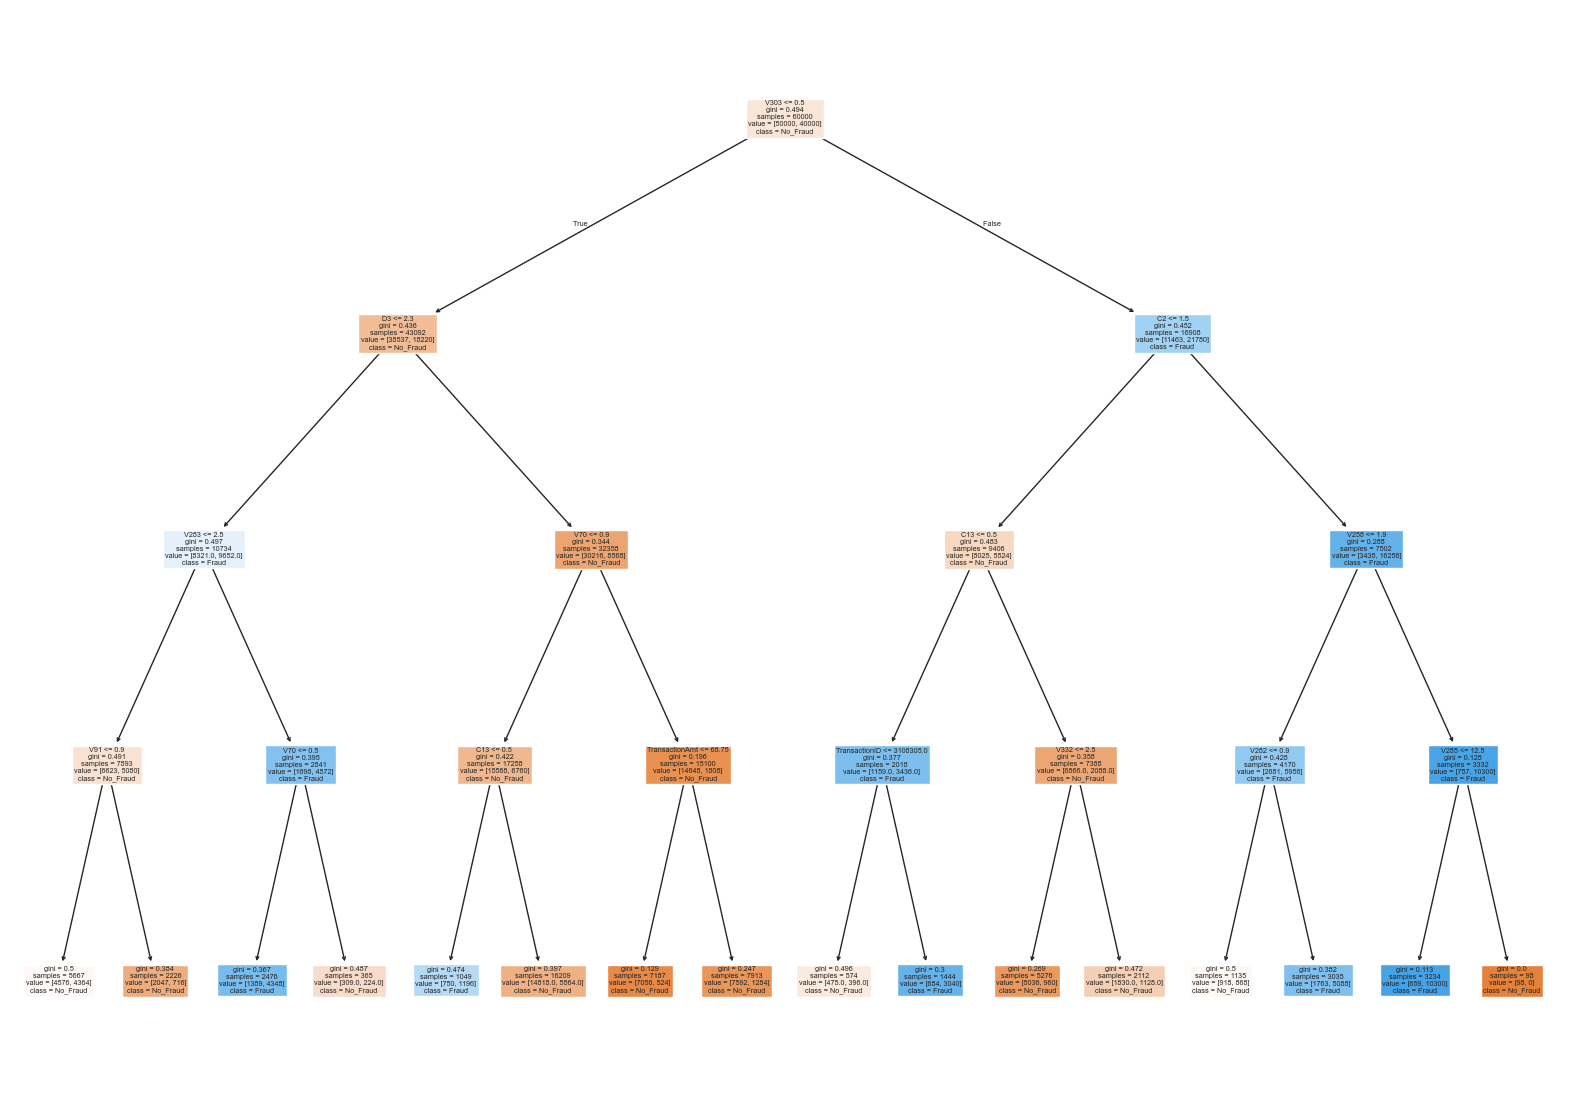

In [464]:
# Visualizando el árbol de decisión
plt.figure(figsize=(20, 14))
plot_tree(
    dtree,  # The tree we want to plot
    feature_names=X_train.columns,  # Take the feature names from the column names in the data
    class_names=["No_Fraud", "Fraud"],  # 0="Negative", 1="Positive"
    filled=True
)
plt.show()

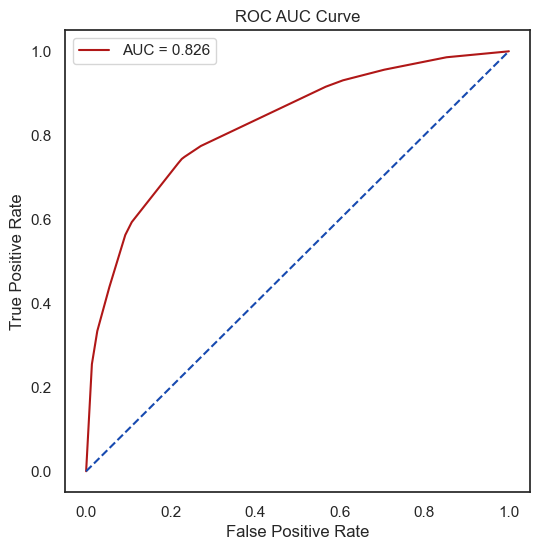

In [466]:
#  Curva ROC
# Calculando tasa de falsos positivos y AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(false_positive_rate, true_positive_rate)

# Construyendo gráfico
sns.set_theme(style = 'white')
plt.figure(figsize = (6, 6))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC AUC Curve')
plt.legend()

# Mostrando gráfico
plt.show()

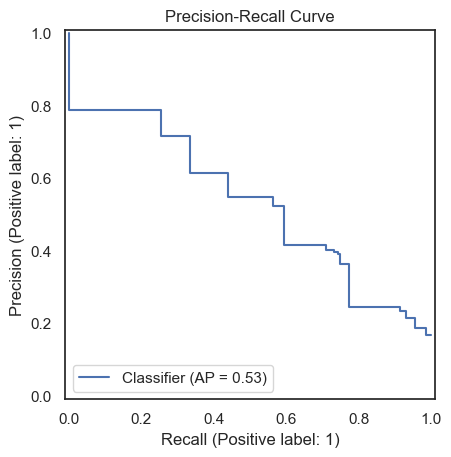

In [468]:
#Precision Recall Curve
PrecisionRecallDisplay.from_predictions(y_test, y_probs)
plt.title('Precision-Recall Curve')

# Mostrando el gráfico
plt.show()

## Modelos supervisados de ensemble

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    Vamos a comprobar cómo es posible mejorar los resultados de detección usando métodos de ensemble. Entrena <b>al menos 5 de los métodos de ensemble vistos en clase</b>, y mide sus resultados de AUC en el test.
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
Algunas sugerencias de modelos disponibles en scikit-learn que puedes utilizar:
    <ul>
        <li>Random Forest</li>
        <li>Extra Trees</li>
        <li>AdaBoost</li>
        <li>Gradient Boosting</li>
        <li>Histogram-based Gradient Boosting</li>
        <li>Bagging</li>
        <li>Voting</li>
        <li>Stacking</li>
    </ul>
No olvides que para medir correctamente el AUC, debes suministrar a esta métrica las <b>probabilidades de clase fraude</b> predichas por el modelo, las cuales puedes obtener mediante el método <i>predict_proba</i>.
    
Si has entrenado los modelos correctamente, tu mejor resultado debería ser de al menos un <b>98% de AUC</b> en test.
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/pro.png" height="80" width="80" style="float: right;"/>

***
<font color=#259b4c>
Adicionalmente, se valorará:
    <ul>
        <li>Utilizar más técnicas de ensembles, además de las 5 mínimas requeridas.</li>
        <li>Mejorar el AUC en test de tu modelo lo máximo posible.</li>
        <li>Utilizar <a href=https://catboost.ai/>CatBoost</a>, <a href=https://lightgbm.readthedocs.io/en/latest/>LightGBM</a> o <a href=https://auto.gluon.ai/>AutoGluon</a>, otras librerías de ensemble muy efectivas. Nótese que deberás instalar estas librerías en el entorno.</li>
    </ul>
</font>

***

In [507]:
# Random Forest
rf = RandomForestClassifier(random_state=21)
rf_params = {
    "n_estimators": [100, 300],                # Número de árboles reducido
    "max_depth": [3, 10, None],                # Opciones clave para profundidad
    "max_features": ["sqrt"],                  # Usamos solo "sqrt" como estándar
    "min_samples_split": [2, 8],               # Divisiones reducidas
    "min_samples_leaf": [1, 4],                # Opciones simples
    "bootstrap": [True],                       # Solo bootstrap activado
    "criterion": ["gini"]                      # Usamos solo "gini"
}

# AdaBoost
adb = AdaBoostClassifier(random_state=21)
adb_params = {
    "n_estimators": [50, 100],                 # Número reducido de iteraciones
    "learning_rate": [0.01, 0.1, 1]           # Tasa de aprendizaje simplificada
}

# Gradient Boosting
gb = GradientBoostingClassifier(random_state=21)
gb_params = {
    "n_estimators": [100, 300],                # Rango de iteraciones reducido
    "learning_rate": [0.01, 0.1, 0.2],         # Opciones estándar para tasa de aprendizaje
    "max_depth": [3, 7, 10],                   # Profundidades prácticas
    "min_samples_split": [2, 8],               # Simplificación de divisiones
    "min_samples_leaf": [1, 4],                # Hojas mínimas reducidas
    "subsample": [0.5, 1],                     # Opciones de muestreo
    "max_features": ["sqrt", "log2"]           # Opciones estándar
}

# Extreme Gradient Boosting
xgb = XGBClassifier(random_state=21)
xgb_params = {
    "gamma": [0, 0.1, 1],                      # Regularización simplificada
    "max_depth": [6, 9],                       # Profundidades reducidas
    "subsample": [0.5, 1.0],                   # Muestreo simple
    "colsample_bytree": [0.5, 0.9],            # Fracción de características
    "reg_lambda": [0, 1, 10]                   # Regularización L2 clave
}

# Histogram-Based Gradient Boosting
hgb = HistGradientBoostingClassifier(random_state=21)
hgb_params = {
    "learning_rate": [0.01, 0.1, 0.2],         # Tasa de aprendizaje limitada
    "max_depth": [3, 10],                      # Opciones de profundidad clave
    "min_samples_leaf": [1, 4],                # Número mínimo de hojas reducido
    "l2_regularization": [0, 1, 10]            # Regularización L2 simplificada
}

# CatBoost
cat = CatBoostClassifier(random_state=21, verbose=0)
cat_params = {
    "iterations": [100, 500],                  # Número reducido de iteraciones
    "learning_rate": [0.01, 0.1],              # Tasa de aprendizaje limitada
    "depth": [3, 7],                           # Profundidad clave
    "bagging_temperature": [1, 5],             # Control de diversidad
    "l2_leaf_reg": [3, 10]                     # Regularización L2 en hojas
}

# LightGBM
lgb = LGBMClassifier(random_state=21)
lgb_params = {
    "n_estimators": [100, 300],                # Número reducido de árboles
    "learning_rate": [0.01, 0.1],              # Tasa de aprendizaje limitada
    "max_depth": [3, 7],                       # Profundidades clave
    "num_leaves": [15, 31],                    # Opciones comunes de hojas
    "min_data_in_leaf": [20, 50],              # Datos mínimos por hoja
    "feature_fraction": [0.7, 1.0],            # Fracción de características
    "lambda_l1": [0, 1],                       # Regularización L1 simplificada
    "lambda_l2": [0, 1]                        # Regularización L2 limitada
}

# Definir los modelos de ensemble
models = [("Random Forest", rf, rf_params), 
          ("AdaBoost", adb, adb_params), 
          ("Gradient Boosting", gb, gb_params),
          ("Extreme Gradient Boosting", xgb, xgb_params),
          ("Histogram Gradient Boosting", hgb, hgb_params),
          ("CatBoost", cat, cat_params),
          ("LightGBM", lgb, lgb_params),]

# Entrenar y evaluar cada modelo
auc_scores = {}

for name, model, params in models:
    random_search = RandomizedSearchCV(model, params, cv=3, n_iter = 20, n_jobs= -1)
    print(f"\nEntrenando {name}...")
    random_search.fit(X_train, y_train)
    y_probs = random_search.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_probs)
    auc_scores[name] = auc_score
    print(f"AUC de {name}: {auc_score:.4f}")


Entrenando Random Forest...
AUC de Random Forest: 0.8920

Entrenando AdaBoost...


C:\Users\Renzo\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AUC de AdaBoost: 0.8414

Entrenando Gradient Boosting...
AUC de Gradient Boosting: 0.8708

Entrenando Extreme Gradient Boosting...
AUC de Extreme Gradient Boosting: 0.8912

Entrenando Histogram Gradient Boosting...
AUC de Histogram Gradient Boosting: 0.8678

Entrenando CatBoost...


C:\Users\Renzo\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
3 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Renzo\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Renzo\anaconda3\Lib\site-packages\catboost\core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\Renzo\anaconda3\Lib\site-packages\catboost\core.py", line 24

AUC de CatBoost: 0.8527

Entrenando LightGBM...
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Number of positive: 10000, number of negativ

## Visualización

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    Crea una visualización mostrando el rendimiento de todos tus modelos supervisados sobre el conjunto de test, junto con el modelo no supervisado. La visualización debe mostrar claramente cuál es el modelo con mayor AUC.
</font>

***

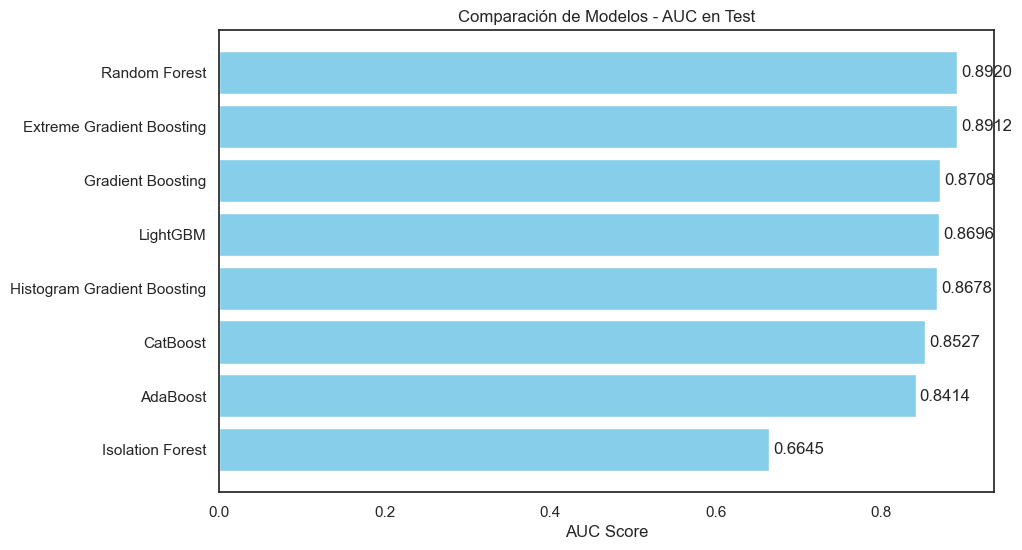

In [513]:
# Agregando auc_scores de Isolation forest
auc_scores['Isolation Forest'] = auc_score_isoforest

# Ordenar por AUC
sorted_models = sorted(auc_scores.items(), key=lambda x: x[1], reverse=True)

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
models, auc_values = zip(*sorted_models)
plt.barh(models, auc_values, color="skyblue")
plt.xlabel("AUC Score")
plt.title("Comparación de Modelos - AUC en Test")
plt.gca().invert_yaxis()  # Invertir el orden para mostrar el mejor modelo arriba

# Agregar etiquetas de AUC en las barras
for index, value in enumerate(auc_values):
    plt.text(value + 0.005, index, f"{value:.4f}", va="center")

plt.show()